In [29]:
!pip install portalocker==2.8.2

In [30]:
import torch
import torchtext
import random
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab
from collections import Counter, OrderedDict
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [31]:
hyper_parameter={
    'batch_size' : 10, #5,16,32,64,128
    'learning_rate' : 1e-3, #1e-1,1e-3,1e-5,1e-7,1e-9
    'N_EPOCHS' : 5,
}

In [32]:
train_iter = IMDB(split='train')
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

def yield_tokens_batch(train_iter):
    for (label, line) in train_iter:
      yield tokenizer(line)
voc = build_vocab_from_iterator(yield_tokens_batch(train_iter), min_freq =3, specials=["<PAD>","<unk>"])
voc.set_default_index(voc['<unk>'])
# label_transform = lambda x: 1 if x == 'pos' else 0
label_transform = lambda x: 1 if x == 2 else 0
text_transform = lambda x: [voc[token] for token in tokenizer(x)]

In [33]:
import numpy as np
train_iter = IMDB(split='train')
test_iter = IMDB(split='test')
train_list = list(train_iter)
random.shuffle(train_list)

dev_list = train_list[:7500]
devfile = open("dev.txt", "w")
for element in dev_list:
    devfile.write(str(element[1]) + str(element[0])+"\n")
devfile.close()

test_list = list(test_iter)
testfile = open("test.txt", "w")
for element in test_list:
    testfile.write(str(element[1])+ str(element[0]) + "\n")
testfile.close()

train_list = train_list[7500:]

In [34]:
len(dev_list)

7500

In [35]:
def collate_batch(batch):
   label_list, text_list = [], []
    # change this thing to be the size per batch
   max_len = 50
   for (_label, _text) in batch:
        label_list.append(label_transform(_label))
        processed_text = torch.LongTensor(text_transform(_text))
        # processed_text = nn.ConstantPad1d((0, max_len - processed_text.shape[0]), 0)(processed_text)
        text_list.append(processed_text)

    # change the padding value (e.g., 0)
   return   pad_sequence(text_list, padding_value=0),torch.LongTensor(label_list)

In [36]:
#5,16,32,64,128
batch_size = hyper_parameter['batch_size']

train_iterator = DataLoader(train_list, batch_size, shuffle=True,
                              collate_fn=collate_batch, drop_last=True)
valid_iterator = DataLoader(dev_list, batch_size, shuffle=False,
                              collate_fn=collate_batch, drop_last=True)
test_iterator = DataLoader(test_list, batch_size, shuffle=False,
                              collate_fn=collate_batch, drop_last=True)
print(f'Number of training examples: {len(train_iterator)}')
print(f'Number of dev examples: {len(valid_iterator)}')
print(f'Number of test examples: {len(test_iterator)}')

Number of training examples: 1750
Number of dev examples: 750
Number of test examples: 2500


In [37]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
device

device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
device

GPU is available


device(type='cuda', index=4)

LR

In [38]:
class LR(nn.Module):
    def __init__(self, input_dim, embedding_dim, output_dim, padding_idx):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=padding_idx)
        self.fc = nn.Linear(embedding_dim, output_dim)
    def forward(self, text):
        embedded = self.embedding(text).squeeze().sum(0)
        return self.fc(embedded)

In [39]:
INPUT_DIM = voc.__len__()
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
PAD_IDX = voc.__getitem__('<PAD>')
model_LR = LR(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM,PAD_IDX)

In [40]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The LR model has {count_parameters(model_LR):,} trainable parameters')

The LR model has 14,583,601 trainable parameters


In [41]:
optimizer = optim.Adam(model_LR.parameters(), lr=hyper_parameter['learning_rate'])

In [42]:
criterion_LR = nn.BCEWithLogitsLoss()

In [43]:
model_LR = model_LR.to(device)
criterion_LR = criterion_LR.to(device)

In [44]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [45]:
from tqdm import tqdm
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for inputs, labels in tqdm(iterator):

        optimizer.zero_grad()

        predictions = model(inputs.to(device)).squeeze(1).to(device)
        # predictions = model(inputs.to(device)).to(device)

        loss = criterion(predictions,labels.float().to(device)).to(device)

        acc = binary_accuracy(predictions, labels.float().to(device))

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [46]:
def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0
    all_prediction = []
    all_labels = []

    model.eval()

    with torch.no_grad():
        for  inputs, labels in iterator:

            predictions = model(inputs.to(device)).squeeze(1).to(device)
            # predictions = model(inputs.to(device)).to(device)

            loss = criterion(predictions,labels.float().to(device)).to(device)

            acc = binary_accuracy(predictions, labels.float().to(device))

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            # predictions = predictions.round().cpu().numpy()
            rounded_preds = torch.round(torch.sigmoid(predictions)).cpu().numpy().astype(int)
            all_prediction.extend(rounded_preds)
            all_labels.extend(labels.cpu().numpy())

    return epoch_loss / len(iterator), epoch_acc / len(iterator), all_prediction, all_labels

In [47]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs, elapsed_time
time_list_LR = []
acc_list_LR = []
acc_list_lr_LR = []

In [49]:
N_EPOCHS = hyper_parameter['N_EPOCHS']

best_valid_loss = float('inf')

total_time=0
last_val_acc=0
last_val_acc_lr=0
final_valid_prediction=[]
final_labels = []

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model_LR, train_iterator, optimizer, criterion_LR)
    valid_loss, valid_acc, valid_prediction, all_labels = evaluate(model_LR, valid_iterator, criterion_LR)

    end_time = time.time()

    epoch_mins, epoch_secs, epoch_total_time = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_LR.state_dict(), 'LR-model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    total_time=total_time+epoch_total_time
    # average_time=total_time/N_EPOCHS
    if epoch == N_EPOCHS - 1:
        last_val_acc=round(valid_acc * 100, 2)
        final_valid_prediction=valid_prediction
        final_labels = all_labels
        
time_tuple=(batch_size,total_time)
acc_tuple=(batch_size,last_val_acc)
acc_tuple_lr=(hyper_parameter['learning_rate'],last_val_acc)
time_list_LR.append(time_tuple)
acc_list_LR.append(acc_tuple)
acc_list_lr_LR.append(acc_tuple_lr)

100%|██████████| 1750/1750 [00:19<00:00, 89.23it/s] 


Epoch: 01 | Epoch Time: 0m 25s
	Train Loss: 0.758 | Train Acc: 82.42%
	 Val. Loss: 0.620 |  Val. Acc: 84.25%


100%|██████████| 1750/1750 [00:18<00:00, 94.26it/s] 


Epoch: 02 | Epoch Time: 0m 24s
	Train Loss: 0.363 | Train Acc: 90.07%
	 Val. Loss: 0.640 |  Val. Acc: 86.03%


100%|██████████| 1750/1750 [00:19<00:00, 90.92it/s] 


Epoch: 03 | Epoch Time: 0m 25s
	Train Loss: 0.237 | Train Acc: 93.66%
	 Val. Loss: 1.078 |  Val. Acc: 83.60%


100%|██████████| 1750/1750 [00:20<00:00, 87.32it/s] 


Epoch: 04 | Epoch Time: 0m 25s
	Train Loss: 0.164 | Train Acc: 95.75%
	 Val. Loss: 0.944 |  Val. Acc: 86.87%


100%|██████████| 1750/1750 [00:19<00:00, 88.07it/s] 


Epoch: 05 | Epoch Time: 0m 25s
	Train Loss: 0.159 | Train Acc: 96.37%
	 Val. Loss: 1.188 |  Val. Acc: 86.87%


In [72]:
model_LR.load_state_dict(torch.load('LR-model.pt'))
comment_text_test=[]
for i in test_list:
    comment_text_test.append(i[1])

test_loss, test_acc, test_prediction, test_lables = evaluate(model_LR, test_iterator, criterion_LR)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.710 | Test Acc: 82.24%


In [ ]:
# Test of model correctness
max_n_test_instances = 5
i = 1
for  inputs, labels in valid_iterator:
  score = model_LR(inputs.to(device))
  print(score)
  if i >= max_n_test_instances:
    break
  else:
    i += 1


tensor([[ -4.3741],
        [  3.8907],
        [-12.1154],
        [-10.6359],
        [ -0.4262],
        [  4.9394],
        [  0.2404],
        [-10.4119],
        [  0.5488],
        [ -7.2704],
        [ -7.1945],
        [ -8.0975],
        [  1.8958],
        [  0.5100],
        [ 11.3260],
        [  4.9712]], device='cuda:4', grad_fn=<AddmmBackward0>)
tensor([[ -0.2356],
        [  3.8024],
        [  4.4169],
        [-13.0050],
        [  0.1618],
        [ -2.5870],
        [ -5.8745],
        [ -9.1785],
        [ -3.5162],
        [-12.2192],
        [-13.6641],
        [  7.4903],
        [ -1.7295],
        [ -0.1594],
        [  5.1686],
        [ -5.3504]], device='cuda:4', grad_fn=<AddmmBackward0>)
tensor([[ -0.8566],
        [-20.1734],
        [ -1.5172],
        [  0.2664],
        [  8.0462],
        [-10.6886],
        [-11.0640],
        [ -3.5249],
        [ 17.7643],
        [  3.7482],
        [-11.6147],
        [ -0.6983],
        [ -4.2689],
        [ -9

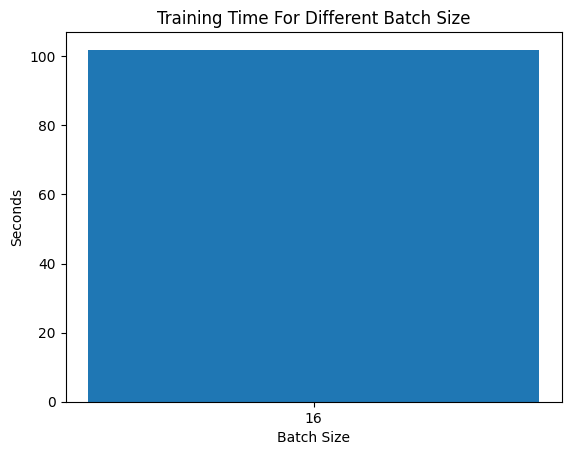

In [ ]:
# plot for compare training time
import matplotlib.pyplot as plt

# acc_list = [(5,10), (16,20), (32,30), (64,40), (128,50)]  
values = [] # List of values
x_labels = [] # Names for each data point
for item in time_list_LR:
    x_labels.append(str(item[0]))
    values.append(item[1])

# Creating the bar chart
plt.bar(x_labels, values)

# Adding title and labels
plt.title('Training Time For Different Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Seconds')

# Show the plot
plt.show()

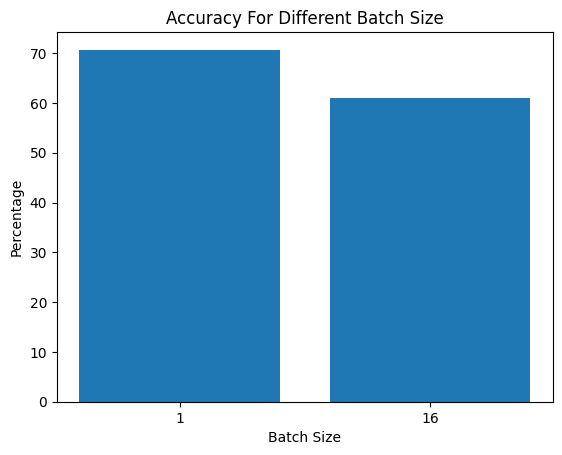

In [ ]:
# plot for compare accuracy
import matplotlib.pyplot as plt

# acc_list = [(5,10), (16,20), (32,30), (64,40), (128,50)]  
values = [] # List of values
x_labels = [] # Names for each data point
for item in acc_list_LR:
    x_labels.append(str(item[0]))
    values.append(item[1])

# Creating the bar chart
plt.bar(x_labels, values)

# Adding title and labels
plt.title('Accuracy For Different Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Percentage')

# Show the plot
plt.show()

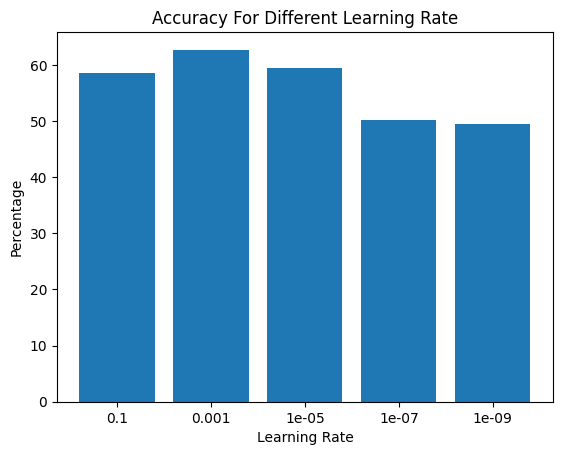

In [ ]:
# plot for compare learning rate
import matplotlib.pyplot as plt

# acc_list = [(5,10), (16,20), (32,30), (64,40), (128,50)]  
values = [] # List of values
x_labels = [] # Names for each data point
for item in acc_list_lr_LR:
    x_labels.append(str(item[0]))
    values.append(item[1])

# Creating the bar chart
plt.bar(x_labels, values)

# Adding title and labels
plt.title('Accuracy For Different Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Percentage')

# Show the plot
plt.show()

In [ ]:
import csv
import pandas as pd
with open('predictions_val.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for pred in final_valid_prediction:
        writer.writerow([pred])
with open('predictions_test.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for pred in test_prediction:
        writer.writerow([pred])
        
df = pd.DataFrame({'Predicted': final_valid_prediction, 'Ground Truth': final_labels})
df.to_csv('predictions_val_comparism.csv', index=False)

In [82]:
comment_text_val=[]
for i in dev_list:
    comment_text_val.append(i[1])

In [83]:
df = pd.DataFrame({'Comment':comment_text_val,'Predicted': final_valid_prediction})
df.to_csv('predictions_val.csv', index=False)

df = pd.DataFrame({'Comment':comment_text_test,'Predicted': test_prediction})
df.to_csv('predictions_test.csv', index=False)